In [1]:
import LinearAlgebra as la
using BenchmarkTools: @btime
include("hoSystem.jl");

In [6]:
import FileIO
import Plots as plt
import ColorVectorSpace
plt.pyplot()
include("util.jl");

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1342
┌ Warning: You are using Matplotlib 3.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots C:\Users\KarlH\.julia\packages\Plots\5kcBO\src\backends\pyplot.jl:29


## Calculating integrals and basis elements

In [2]:
l_0 = 10  # number of basis functions
ω = 0.25  # strength of harmonic oscillator potential
a = 0.25  # shielding term in coloumb interaction
grid = [x for x in range(-10, stop = 10, length = 2001)]
n = 2     # number of particles

@time system = System(n, HOBasis(l_0, ω, a), grid);

  1.356762 seconds (5.05 M allocations: 298.604 MiB, 5.01% gc time, 7.96% compilation time)


## Hartree-Fock Calculation

In [3]:
function getP(C, system)
    n, l = system.n, system.l
    
    P = la.zeros((l, l))
    for i in 1:n
        for a in 1:l
            for b in 1:l
                @inbounds P[b, a] += conj(C[a, i]) * C[b, i]
            end
        end
    end
    return P
end

function getF(P, system)
    h, u, n, l = system.h, system.u, system.n, system.l
    
    F = la.zeros((l, l))
    F .+= h
    for c in 1:l
        for d in 1:l
            @inbounds P_dc = P[d, c]
            for a in 1:l
                for b in 1:l
                    @inbounds F[a, b] += P_dc * u[a, c, b, d]
                end
            end
        end
    end
    return F
end

function SCF(C, system, iters)
    for i in 1:iters
        P = getP(C, system)
        F = getF(P, system)
        C = la.eigvecs(F)
    end
    
    return C
end

SCF (generic function with 1 method)

In [5]:
#C_initial = ComplexF64.(la.I(system.l));
C_initial = la.Matrix(Float64.(la.I(system.l)))

@time C = SCF(C_initial, system, 20000);

  3.650905 seconds (360.00 k allocations: 945.435 MiB, 2.20% gc time)


In [ ]:
3.489390 seconds (360.00 k allocations: 945.435 MiB, 1.45% gc time)

## Results

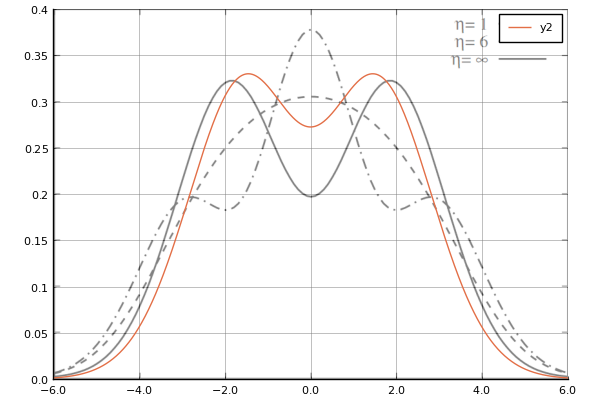

In [12]:
ψ = [abs.(i).^2 for i in (system.spfs .* C[:, 1])] .+ [abs.(i).^2 for i in (system.spfs .* C[:, 2])]
ψ = sum(ψ);

x_trans, y_trans = imgplot(file     = "Images/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(x_trans.(grid), y_trans.(ψ))

In [8]:
function expected_energy(C, system)
    l = system.l
    P = getP(C, system)
    h = system.h
    u = system.u
    
    energy = 0.0
    for a in 1:l
        for b in 1:l
            @inbounds energy += P[b, a] * h[a, b]
            for c in 1:l
                for d in 1:l
                    @inbounds energy += 0.5 * P[b, a] * P[d, c] * u[a, c, b, d]
                end
            end
        end
    end
    return real(energy)
end

expected_energy (generic function with 1 method)

In [9]:
expected_energy(C, system)

0.8450412300560405